In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr

%reload_ext autoreload
%autoreload 2
from HelperFunctions import plot_corr, minibatch, subcategoryttest, subcategoryANOVA

In [2]:
df=pd.read_csv('lean_df_3.csv',index_col='id')

/home/auscheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (35,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/auscheng/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


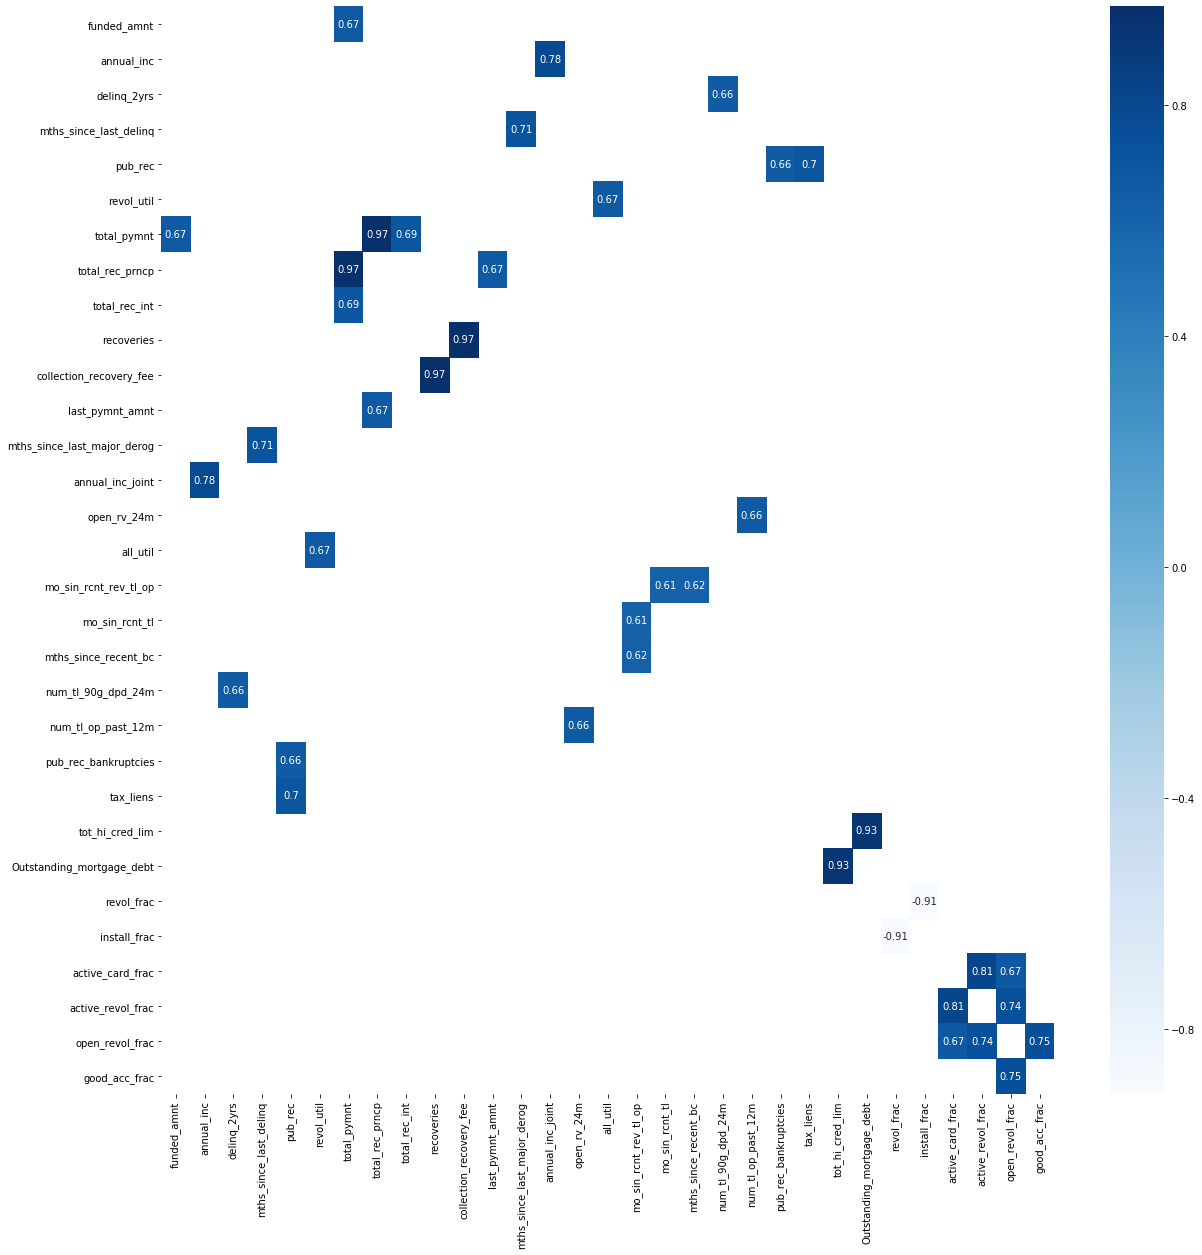

In [3]:
plot_corr(df,threshold=0.6,size=20)

#### We don't care about the type of accounts opened but the actual utilization of the type of accounts.
#### drop the revolving and installment accounts opened in past months info.

In [4]:
df.drop(['open_rv_24m','open_il_12m'],axis=1,inplace=True)
# list(df.columns)

In [5]:
# Keep: df.loc[:,['tot_hi_cred_lim','total_il_high_credit_limit','total_rev_hi_lim']]

In [6]:
df_number = df.select_dtypes(include = 'number')
df_object = df.select_dtypes(include = 'object')
df_category = df.select_dtypes(include = 'category')
df_boolean = df.select_dtypes(include = 'bool')
df_datetime = df.select_dtypes(include = 'datetime')
df_timedelta = df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

#### Dropping features not known during issuance date. Will need to keep a couple to create the target variable

In [7]:
#### Features not known during issuance date or is current: 
# out_prncp_inv             <---- drop
# total_pymnt               <--- KEEP to create target variable (profit for total yield)
# total_pymnt_inv           <---- drop
# total_rec_prncp           <---- drop
# total_rec_int             <---- drop
# total_rec_late_fee        <---- drop
# recoveries                <---- drop
# collection_recovery_fee   <---- KEEP to create target variable (profit for total yield)
# last_pymnt_d              <---- KEEP to create loan duration 
# last_pymnt_amnt           <---- drop
# next_pymnt_d              <---- drop
# last_credit_pull_d        <---- drop

In [8]:
df.drop(['total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d'],axis=1,inplace=True)

#### dropping oldest account opened because covered by earlieset credit line

In [9]:
df.drop(['mo_sin_old_il_acct','mo_sin_old_rev_tl_op'],axis=1,inplace=True)

# Human intuition feature elimination
#### 'emp_title' has too many subcategories. it is also self reporting. purpose more important
#### inq_last_6_mnths is covered by inq_last_12m
#### out_prncp is not known before issuance and is not relevant for target variable calculation
#### mths_since_rcnt_il is covered by mo_sin_rcnt_tl (months since latest account)
#### max_bal_bc is covered by total outstanding balance
#### inq_fi the personal finance factor is too mysterious. we are not sure of its effect and it has relatively few observations, so drop
#### total_cu_tl is dropped for same reason as above and should be covered by 
#### mo_sin_rcnt_rev_tl_op covered by mo_sin_rcnt_tl (months since latest account)
#### mths_since_recent_bc covered by mo_sin_rcnt_tl (months since latest account)
#### mths_since_recent_inq covered by inq_last_12m
#### num_bc_sats covered by num_sats --> good_accounts
#### num_tl_120dpd_2m has a time window that is too short and is covered by num_tl_90g_dpd_24m

In [10]:
df.drop(['emp_title','inq_last_6mths','out_prncp','mths_since_rcnt_il',\
         'max_bal_bc','inq_fi','total_cu_tl','mo_sin_rcnt_rev_tl_op',\
         'mths_since_recent_bc','mths_since_recent_inq','num_bc_sats','num_tl_120dpd_2m',\
         'fully_invested'],axis=1,inplace=True)

In [11]:
df.head()

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_util,total_acc,initial_list_status,total_pymnt,collection_recovery_fee,last_pymnt_d,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,il_util,all_util,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36 months,13.99,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,30.0,NaN,0.0,29.7,13.0,w,4421.723917,0.0,Jan-2019,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,36.0,34.0,9300.0,4.0,0.0,0.0,3.0,2.0,0.0,3.0,76.9,0.0,0.0,178050.0,13734.0,677.0,137158.0,0.692308,0.230769,0.076923,0.555556,0.400000,0.444444,0.666667,0.444444,0.538462
68355089,24700.0,36 months,11.99,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,577xx,SD,16.06,1.0,Dec-1999,6.0,NaN,0.0,19.2,38.0,w,25679.660000,0.0,Jun-2016,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,73.0,29.0,111800.0,6.0,0.0,0.0,2.0,0.0,0.0,2.0,97.4,0.0,0.0,314017.0,24667.0,717.0,164921.0,0.710526,0.157895,0.105263,0.629630,0.294118,0.185185,0.166667,0.740741,0.578947
68341763,20000.0,60 months,10.78,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,605xx,IL,10.78,0.0,Aug-2000,NaN,NaN,0.0,56.2,18.0,w,22705.924294,0.0,Jun-2017,0.0,NaN,Joint App,71000.0,13.85,Not Verified,0.0,0.0,73.0,65.0,14000.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,100.0,0.0,0.0,218418.0,14877.0,697.0,171003.0,0.388889,0.333333,0.277778,0.571429,0.500000,0.428571,0.166667,0.571429,0.333333
66310712,35000.0,60 months,14.85,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,NaN,NaN,0.0,11.6,17.0,w,31464.010000,0.0,Feb-2019,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,70.0,45.0,67300.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,18000.0,787.0,249274.0,0.764706,0.117647,0.058824,0.769231,0.400000,0.384615,0.500000,0.769231,0.764706
68476807,10400.0,60 months,22.45,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,174xx,PA,25.37,1.0,Jun-1998,12.0,NaN,0.0,64.5,35.0,w,11740.500000,0.0,Jul-2016,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,84.0,78.0,34000.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,96.6,0.0,0.0,439570.0,88097.0,697.0,235962.0,0.542857,0.285714,0.171429,0.473684,0.444444,0.315789,0.300000,0.368421,0.342857


In [12]:
df.shape

(2260668, 60)

In [13]:
# df.loc[:,['issue_d','loan_status','last_pymnt_d','next_pymnt_d']].iloc[0:50,:]

#### Making loan status a binary output variable 

In [14]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
df.loc[(df.loan_status=='Late (31-120 days)')|(df.loan_status=='Late (16-30 days)')|\
       (df.loan_status=='In Grace Period'),'loan_status']='Current'
df.loc[(df.loan_status=='Charged Off')|\
       (df.loan_status=='Does not meet the credit policy. Status:Charged Off'),'loan_status']='Default'
df.loc[(df.loan_status=='Does not meet the credit policy. Status:Fully Paid'),'loan_status']='Fully Paid'

In [16]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Default'], dtype=object)

#### Turning time columns into proper datetime formats

In [17]:
df.issue_d=pd.to_datetime(df.issue_d)
df.earliest_cr_line=pd.to_datetime(df.earliest_cr_line)
df.last_pymnt_d=pd.to_datetime(df.last_pymnt_d)

In [18]:
pattern='([0-9][0-9]) months'
df['term']=df['term'].str.extract(pattern).values
df['term']=df['term'].astype('int')

In [19]:
df['term'].iloc[0]

36

In [20]:
# df.sort_values(by='issue_d')

# Creating new columns. Loan Duration and Profit
#### loan_duration=last_pyment_d-issue_d, profit=total_pymnt-collection_recovery_fee
#### Then dropping last_pyment_d, total_pymnt, collection_recovery_fee

In [21]:
df['loan_duration']=df['last_pymnt_d']-df['issue_d']
df['profit']=df['total_pymnt']-df['collection_recovery_fee']
df.drop(['last_pymnt_d','total_pymnt','collection_recovery_fee'],axis=1,inplace=True)

In [22]:
df.sample(10)

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,il_util,all_util,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,profit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
58683439,13000.0,60,10.99,B,B4,3 years,MORTGAGE,70000.0,Not Verified,2015-08-01,Current,debt_consolidation,151xx,PA,18.64,1.0,2004-02-01,21.0,NaN,0.0,90.5,14.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,NaN,NaN,13100.0,NaN,0.0,0.0,29.0,0.0,0.0,0.0,92.9,0.0,0.0,117455.0,46711.0,692.0,52173.0,0.428571,0.357143,0.214286,0.666667,0.500000,0.666667,NaN,0.666667,0.500000,1308 days,12143.430000
15930891,5000.0,36,16.99,D,D3,5 years,RENT,100000.0,Source Verified,2014-05-01,Fully Paid,moving,600xx,IL,18.47,3.0,2005-07-01,10.0,NaN,0.0,92.8,25.0,f,0.0,17.0,Individual,NaN,NaN,NaN,0.0,0.0,NaN,NaN,10800.0,NaN,0.0,0.0,13.0,4.0,2.0,0.0,80.0,0.0,0.0,88361.0,77561.0,662.0,0.0,0.360000,0.400000,0.240000,0.444444,0.750000,0.555556,NaN,0.777778,0.360000,1096 days,6416.582038
58513205,3000.0,36,11.53,B,B5,10+ years,RENT,87600.0,Source Verified,2015-09-01,Default,debt_consolidation,926xx,CA,20.62,0.0,1999-03-01,34.0,NaN,0.0,91.4,25.0,w,0.0,34.0,Individual,NaN,NaN,NaN,0.0,0.0,NaN,NaN,12100.0,NaN,0.0,0.0,4.0,2.0,0.0,4.0,88.0,0.0,0.0,56244.0,44144.0,667.0,0.0,0.560000,0.440000,0.000000,0.714286,0.500000,0.500000,NaN,0.571429,0.480000,243 days,999.388600
137992941,10000.0,60,18.94,D,D2,10+ years,MORTGAGE,70000.0,Source Verified,2018-08-01,Current,credit_card,378xx,TN,15.52,0.0,1997-05-01,NaN,NaN,0.0,31.4,43.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,4670.0,92.0,49.0,54800.0,2.0,0.0,0.0,5.0,0.0,0.0,3.0,100.0,0.0,0.0,77490.0,22690.0,672.0,0.0,0.837209,0.162791,0.000000,0.388889,0.357143,0.361111,0.142857,0.583333,0.511628,212 days,1803.040000
127039534,27000.0,36,10.42,B,B3,10+ years,MORTGAGE,120773.9,Verified,2018-01-01,Fully Paid,debt_consolidation,902xx,CA,8.07,0.0,1991-10-01,NaN,NaN,0.0,89.5,26.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,NaN,90.0,40300.0,4.0,0.0,0.0,10.0,0.0,0.0,1.0,100.0,0.0,0.0,584300.0,0.0,702.0,538644.0,0.846154,0.038462,0.115385,0.681818,0.266667,0.181818,0.000000,0.227273,0.230769,212 days,28510.532713
109965827,10000.0,36,15.05,C,C4,< 1 year,RENT,60000.0,Source Verified,2017-06-01,Default,debt_consolidation,117xx,NY,15.46,0.0,2003-06-01,51.0,NaN,0.0,28.0,31.0,f,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,98.0,28.0,41910.0,4.0,0.0,0.0,1.0,0.0,0.0,9.0,97.0,0.0,0.0,61274.0,19364.0,672.0,0.0,0.935484,0.064516,0.000000,0.379310,0.727273,0.724138,1.000000,0.724138,0.741935,395 days,5274.239200
48806263,5000.0,36,13.99,C,C4,1 year,MORTGAGE,75000.0,Not Verified,2015-05-01,Fully Paid,debt_consolidation,750xx,TX,25.78,2.0,2003-07-01,19.0,68.0,1.0,46.8,41.0,f,0.0,72.0,Individual,NaN,NaN,NaN,0.0,0.0,NaN,NaN,15300.0,NaN,0.0,0.0,4.0,2.0,0.0,3.0,93.5,1.0,0.0,134542.0,119242.0,662.0,0.0,0.560976,0.317073,0.097561,0.695652,0.312500,0.260870,NaN,0.304348,0.268293,1096 days,6147.157520
71758209,20000.0,36,14.46,C,C4,7 years,RENT,153000.0,Verified,2016-02-01,Current,other,921xx,CA,9.64,0.0,1989-03-01,NaN,NaN,0.0,69.2,11.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,215.0,56.0,64.0,57500.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,100.0,0.0,0.0,82999.0,24083.0,682.0,0.0,0.727273,0.181818,0.000000,1.000000,0.625000,0.625000,0.500000,0.750000,0.727273,1124 days,24829.288189
708769

# Injecting a random dummy variable for feature importance reference

In [23]:
df['RANDOM']=np.random.uniform(0,1,df.shape[0])

# Renaming Columns to Something Understandable

In [24]:
df.head(5)

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,il_util,all_util,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,profit,RANDOM
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,debt_consolidation,190xx,PA,5.91,0.0,2003-08-01,30.0,NaN,0.0,29.7,13.0,w,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,36.0,34.0,9300.0,4.0,0.0,0.0,3.0,2.0,0.0,3.0,76.9,0.0,0.0,178050.0,13734.0,677.0,137158.0,0.692308,0.230769,0.076923,0.555556,0.400000,0.444444,0.666667,0.444444,0.538462,1127 days,4421.723917,0.232250
68355089,24700.0,36,11.99,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,small_business,577xx,SD,16.06,1.0,1999-12-01,6.0,NaN,0.0,19.2,38.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,73.0,29.0,111800.0,6.0,0.0,0.0,2.0,0.0,0.0,2.0,97.4,0.0,0.0,314017.0,24667.0,717.0,164921.0,0.710526,0.157895,0.105263,0.629630,0.294118,0.185185,0.166667,0.740741,0.578947,183 days,25679.660000,0.842660
68341763,20000.0,60,10.78,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,Fully Paid,home_improvement,605xx,IL,10.78,0.0,2000-08-01,NaN,NaN,0.0,56.2,18.0,w,0.0,NaN,Joint App,71000.0,13.85,Not Verified,0.0,0.0,73.0,65.0,14000.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,100.0,0.0,0.0,218418.0,14877.0,697.0,171003.0,0.388889,0.333333,0.277778,0.571429,0.500000,0.428571,0.166667,0.571429,0.333333,548 days,22705.924294,0.075308
66310712,35000.0,60,14.85,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,2015-12-01,Current,debt_consolidation,076xx,NJ,17.06,0.0,2008-09-01,NaN,NaN,0.0,11.6,17.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,70.0,45.0,67300.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,18000.0,787.0,249274.0,0.764706,0.117647,0.058824,0.769231,0.400000,0.384615,0.500000,0.769231,0.764706,1158 days,31464.010000,0.297345
68476807,10400.0,60,22.45,F,F1,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,Fully Paid,major_purchase,174xx,PA,25.37,1.0,1998-06-01,12.0,NaN,0.0,64.5,35.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,84.0,78.0,34000.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,96.6,0.0,0.0,439570.0,88097.0,697.0,235962.0,0.542857,0.285714,0.171429,0.473684,0.444444,0.315789,0.300000,0.368421,0.342857,213 days,11740.500000,0.359844


In [25]:
df.rename(columns={'total_il_high_credit_limit':'install_credit',
                   'tot_hi_cred_lim':'total_credit',
                   'pct_tl_nvr_dlq':'pct_acc_nvr_dlq',
                   'num_tl_op_past_12m':'accs_opened_past_12m',
                   'num_tl_90g_dpd_24m':'accs_90days+_PastDue_24m',
                   'num_accts_ever_120_pd':'all_accs_120days+_PastDue_ever',
                   'mo_sin_rcnt_tl':'mths_since_RecentAcc_opened',
                   'total_rev_hi_lim':'rev_credit',
                   'il_util':'install_util',
                   'tot_coll_amt':'collection_amt',
                   'pub_rec':'derog_records',
                   'mths_since_last_record':'mths_since_last_derog_record'},inplace=True)

In [26]:
df.head()

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,profit,RANDOM
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,debt_consolidation,190xx,PA,5.91,0.0,2003-08-01,30.0,NaN,0.0,29.7,13.0,w,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,36.0,34.0,9300.0,4.0,0.0,0.0,3.0,2.0,0.0,3.0,76.9,0.0,0.0,178050.0,13734.0,677.0,137158.0,0.692308,0.230769,0.076923,0.555556,0.400000,0.444444,0.666667,0.444444,0.538462,1127 days,4421.723917,0.232250
68355089,24700.0,36,11.99,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,small_business,577xx,SD,16.06,1.0,1999-12-01,6.0,NaN,0.0,19.2,38.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,73.0,29.0,111800.0,6.0,0.0,0.0,2.0,0.0,0.0,2.0,97.4,0.0,0.0,314017.0,24667.0,717.0,164921.0,0.710526,0.157895,0.105263,0.629630,0.294118,0.185185,0.166667,0.740741,0.578947,183 days,25679.660000,0.842660
68341763,20000.0,60,10.78,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,Fully Paid,home_improvement,605xx,IL,10.78,0.0,2000-08-01,NaN,NaN,0.0,56.2,18.0,w,0.0,NaN,Joint App,71000.0,13.85,Not Verified,0.0,0.0,73.0,65.0,14000.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,100.0,0.0,0.0,218418.0,14877.0,697.0,171003.0,0.388889,0.333333,0.277778,0.571429,0.500000,0.428571,0.166667,0.571429,0.333333,548 days,22705.924294,0.075308
66310712,35000.0,60,14.85,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,2015-12-01,Current,debt_consolidation,076xx,NJ,17.06,0.0,2008-09-01,NaN,NaN,0.0,11.6,17.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,70.0,45.0,67300.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,18000.0,787.0,249274.0,0.764706,0.117647,0.058824,0.769231,0.400000,0.384615,0.500000,0.769231,0.764706,1158 days,31464.010000,0.297345
68476807,10400.0,60,22.45,F,F1,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,Fully Paid,major_purchase,174xx,PA,25.37,1.0,1998-06-01,12.0,NaN,0.0,64.5,35.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,84.0,78.0,34000.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,96.6,0.0,0.0,439570.0,88097.0,697.0,235962.0,0.542857,0.285714,0.171429,0.473684,0.444444,0.315789,0.300000,0.368421,0.342857,213 days,11740.500000,0.359844


# Checking subcategories

F_onewayResult(statistic=32951.38507472482, pvalue=0.0)

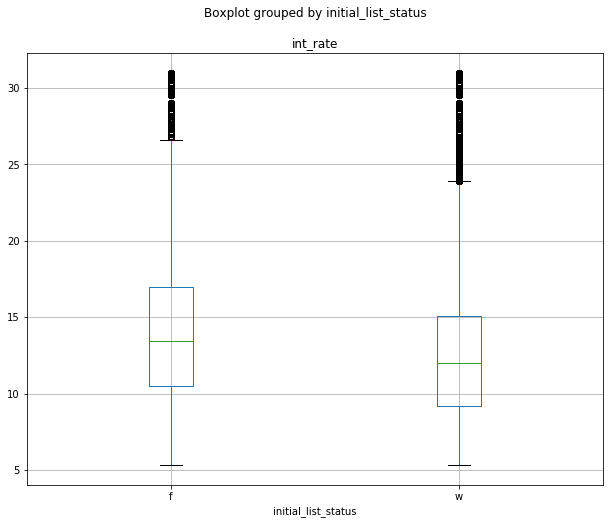

In [27]:
subcategoryANOVA(df,'initial_list_status','int_rate')

In [28]:
subcategoryttest(df,'loan_status','Fully Paid','Default','int_rate')

Ttest_indResult(statistic=-310.7971914386984, pvalue=0.0)

In [29]:
df.to_csv('lean_df_4.csv')